# Brain Tumor Detection using CNN and tranfer learning

_We will create a model which will correctly classify if the MRI image of the brain has tumor or not._

# Importing necessary libraries

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K

import cv2
import shutil
import glob
import os

# Data import & preprocessing

In [24]:
#data = '../input/augmented-dataset/'
#No_brain_tumor = '../input/augmented-dataset/no/no/'
#Yes_brain_tumor = '../input/augmented-dataset/yes/yes'

data = '../input/brain-mri-images-for-brain-tumor-detection/'
No_brain_tumor = '../input/brain-mri-images-for-brain-tumor-detection/no/'
Yes_brain_tumor = '../input/brain-mri-images-for-brain-tumor-detection/no/'

In [25]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  196    labels:  196


In [26]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(196,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,../input/brain-mri-images-for-brain-tumor-dete...,No
1,../input/brain-mri-images-for-brain-tumor-dete...,No
2,../input/brain-mri-images-for-brain-tumor-dete...,No
3,../input/brain-mri-images-for-brain-tumor-dete...,No
4,../input/brain-mri-images-for-brain-tumor-dete...,No


In [27]:
print(df['labels'].value_counts())

No     98
Yes    98
Name: labels, dtype: int64


# visualize brain tumor images

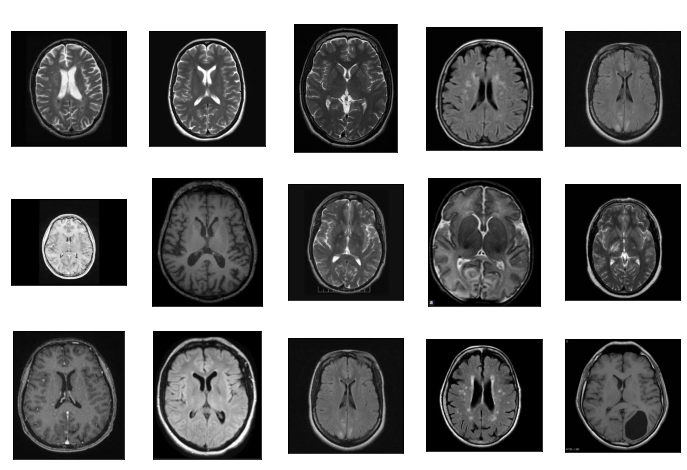

In [28]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [29]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (167, 2)
test set shape: (10, 2)
validation set shape: (19, 2)


# Data Augmentation

In [30]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

Now fit the them to get the images from directory (name of the images are given in dataframe) with augmentation

In [31]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (150,150), batch_size = 16, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 167 validated image filenames belonging to 2 classes.
Found 19 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.


In [32]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

# CNN model

In [33]:
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_407 (Bat (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 54,534,113
Trainable params: 54,473,313
Non-trainable params: 60,800
_____________________________________

In [34]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
]


model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 40, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/40
11/11 [==============================] - 24s 570ms/step - loss: 0.8912 - accuracy: 0.5198 - val_loss: 0.9389 - val_accuracy: 0.3158
Epoch 2/40
11/11 [==============================] - 2s 180ms/step - loss: 0.9406 - accuracy: 0.4763 - val_loss: 0.7251 - val_accuracy: 0.5789
Epoch 3/40
11/11 [==============================] - 2s 185ms/step - loss: 0.8596 - accuracy: 0.4831 - val_loss: 0.8704 - val_accuracy: 0.3684
Epoch 4/40
11/11 [==============================] - 3s 238ms/step - loss: 0.7596 - accuracy: 0.5199 - val_loss: 1.0100 - val_accuracy: 0.4211
Epoch 5/40
11/11 [==============================] - 2s 186ms/step - loss: 0.8810 - accuracy: 0.5255 - val_loss: 0.9288 - val_accuracy: 0.3684
Epoch 00005: early stopping


In [35]:
model.load_weights("Tumor_classifier_model.h5")
model.evaluate(test_gen)

1/1 [==============================] - 0s 292ms/step - loss: 0.6212 - accuracy: 0.7000


[0.6212126016616821, 0.699999988079071]

# plot model performance

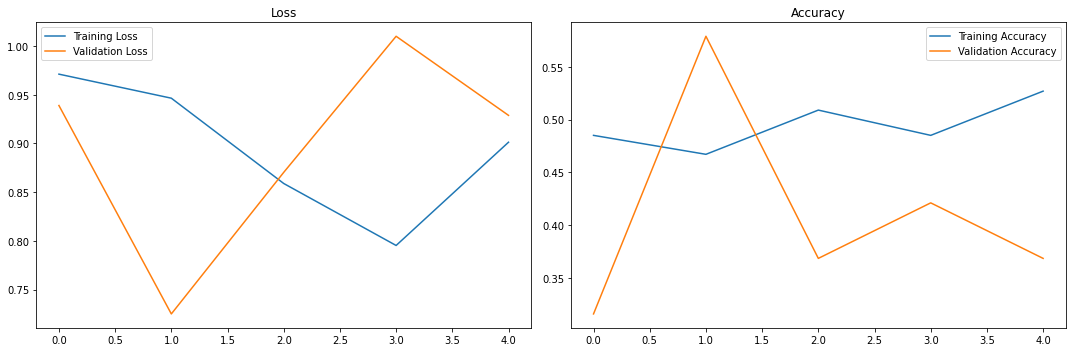

In [36]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))
    # Loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
    
    # Accuracy
plt.subplot(1, 2, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
    
plt.tight_layout()
plt.show()